## Blending Ensemble Machine Learning With Python
This notebook is courtesy of this [post](https://machinelearningmastery.com/blending-ensemble-machine-learning-with-python/#:~:text=Blending%20is%20an%20ensemble%20machine%20learning%20technique%20that%20uses%20a,known%20as%20stacking%2C%20broadly%20conceived). You can read it for more details.

In [3]:
# evaluate base models on the entire training dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
	return X, y

# get a list of base models
def get_models():
	models = list()
	models.append(('lr', LogisticRegression()))
	models.append(('knn', KNeighborsClassifier()))
	models.append(('cart', DecisionTreeClassifier()))
	models.append(('svm', SVC(probability=True)))
	models.append(('bayes', GaussianNB()))
	return models

# define dataset
X, y = get_dataset()
# split dataset into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
# summarize data split
print('Train: %s, Test: %s' % (X_train_full.shape, X_test.shape))
# create the base models
models = get_models()
# evaluate standalone model
for name, model in models:
	# fit the model on the training dataset
	model.fit(X_train_full, y_train_full)
	# make a prediction on the test dataset
	yhat = model.predict(X_test)
	# evaluate the predictions
	score = accuracy_score(y_test, yhat)
	# report the score
	print('>%s Accuracy: %.3f' % (name, score*100))

Train: (5000, 20), Test: (5000, 20)
>lr Accuracy: 87.800
>knn Accuracy: 97.380
>cart Accuracy: 88.600
>svm Accuracy: 98.200
>bayes Accuracy: 87.300


In [4]:
# blending ensemble for classification using hard voting
from numpy import hstack
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
	return X, y

# get a list of base models
def get_models():
	models = list()
	models.append(('lr', LogisticRegression()))
	models.append(('knn', KNeighborsClassifier()))
	models.append(('cart', DecisionTreeClassifier()))
	models.append(('svm', SVC()))
	models.append(('bayes', GaussianNB()))
	return models

# fit the blending ensemble
def fit_ensemble(models, X_train, X_val, y_train, y_val):
	# fit all models on the training set and predict on hold out set
	meta_X = list()
	for name, model in models:
		# fit in training set
		model.fit(X_train, y_train)
		# predict on hold out set
		yhat = model.predict(X_val)
		# reshape predictions into a matrix with one column
		yhat = yhat.reshape(len(yhat), 1)
		# store predictions as input for blending
		meta_X.append(yhat)
	# create 2d array from predictions, each set is an input feature
	meta_X = hstack(meta_X)
	# define blending model
	blender = LogisticRegression()
	# fit on predictions from base models
	blender.fit(meta_X, y_val)
	return blender

# make a prediction with the blending ensemble
def predict_ensemble(models, blender, X_test):
	# make predictions with base models
	meta_X = list()
	for name, model in models:
		# predict with base model
		yhat = model.predict(X_test)
		# reshape predictions into a matrix with one column
		yhat = yhat.reshape(len(yhat), 1)
		# store prediction
		meta_X.append(yhat)
	# create 2d array from predictions, each set is an input feature
	meta_X = hstack(meta_X)
	# predict
	return blender.predict(meta_X)

# define dataset
X, y = get_dataset()
# split dataset into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
# split training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.33, random_state=1)
# summarize data split
print('Train: %s, Val: %s, Test: %s' % (X_train.shape, X_val.shape, X_test.shape))
# create the base models
models = get_models()
# train the blending ensemble
blender = fit_ensemble(models, X_train, X_val, y_train, y_val)
# make predictions on test set
yhat = predict_ensemble(models, blender, X_test)
# evaluate predictions
score = accuracy_score(y_test, yhat)
print('Blending Accuracy: %.3f' % (score*100))

Train: (3350, 20), Val: (1650, 20), Test: (5000, 20)
Blending Accuracy: 97.760


In [5]:
# blending ensemble for classification using soft voting
from numpy import hstack
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
	return X, y

# get a list of base models
def get_models():
	models = list()
	models.append(('lr', LogisticRegression()))
	models.append(('knn', KNeighborsClassifier()))
	models.append(('cart', DecisionTreeClassifier()))
	models.append(('svm', SVC(probability=True)))
	models.append(('bayes', GaussianNB()))
	return models

# fit the blending ensemble
def fit_ensemble(models, X_train, X_val, y_train, y_val):
	# fit all models on the training set and predict on hold out set
	meta_X = list()
	for name, model in models:
		# fit in training set
		model.fit(X_train, y_train)
		# predict on hold out set
		yhat = model.predict_proba(X_val)
		# store predictions as input for blending
		meta_X.append(yhat)
	# create 2d array from predictions, each set is an input feature
	meta_X = hstack(meta_X)
	# define blending model
	blender = LogisticRegression()
	# fit on predictions from base models
	blender.fit(meta_X, y_val)
	return blender

# make a prediction with the blending ensemble
def predict_ensemble(models, blender, X_test):
	# make predictions with base models
	meta_X = list()
	for name, model in models:
		# predict with base model
		yhat = model.predict_proba(X_test)
		# store prediction
		meta_X.append(yhat)
	# create 2d array from predictions, each set is an input feature
	meta_X = hstack(meta_X)
	# predict
	return blender.predict(meta_X)

# define dataset
X, y = get_dataset()
# split dataset into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
# split training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.33, random_state=1)
# summarize data split
print('Train: %s, Val: %s, Test: %s' % (X_train.shape, X_val.shape, X_test.shape))
# create the base models
models = get_models()
# train the blending ensemble
blender = fit_ensemble(models, X_train, X_val, y_train, y_val)
# make predictions on test set
yhat = predict_ensemble(models, blender, X_test)
# evaluate predictions
score = accuracy_score(y_test, yhat)
print('Blending Accuracy: %.3f' % (score*100))

Train: (3350, 20), Val: (1650, 20), Test: (5000, 20)
Blending Accuracy: 98.240


Exercise: Are you able to beat the above accuracy? Create a set of blended/stacked classifiers that can beat the above accuracies.

In [6]:
#Code Goes here

In [7]:
# evaluate base models in isolation on the regression dataset
from numpy import hstack
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# get the dataset
def get_dataset():
	X, y = make_regression(n_samples=10000, n_features=20, n_informative=10, noise=0.3, random_state=7)
	return X, y

# get a list of base models
def get_models():
	models = list()
	models.append(('lr', LinearRegression()))
	models.append(('knn', KNeighborsRegressor()))
	models.append(('cart', DecisionTreeRegressor()))
	models.append(('svm', SVR()))
	return models

# define dataset
X, y = get_dataset()
# split dataset into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
# summarize data split
print('Train: %s, Test: %s' % (X_train_full.shape, X_test.shape))
# create the base models
models = get_models()
# evaluate standalone model
for name, model in models:
	# fit the model on the training dataset
	model.fit(X_train_full, y_train_full)
	# make a prediction on the test dataset
	yhat = model.predict(X_test)
	# evaluate the predictions
	score = mean_absolute_error(y_test, yhat)
	# report the score
	print('>%s MAE: %.3f' % (name, score))

Train: (5000, 20), Test: (5000, 20)
>lr MAE: 0.236
>knn MAE: 100.169
>cart MAE: 132.614
>svm MAE: 138.195


In [8]:
# evaluate blending ensemble for regression
from numpy import hstack
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# get the dataset
def get_dataset():
	X, y = make_regression(n_samples=10000, n_features=20, n_informative=10, noise=0.3, random_state=7)
	return X, y

# get a list of base models
def get_models():
	models = list()
	models.append(('lr', LinearRegression()))
	models.append(('knn', KNeighborsRegressor()))
	models.append(('cart', DecisionTreeRegressor()))
	models.append(('svm', SVR()))
	return models

# fit the blending ensemble
def fit_ensemble(models, X_train, X_val, y_train, y_val):
	# fit all models on the training set and predict on hold out set
	meta_X = list()
	for name, model in models:
		# fit in training set
		model.fit(X_train, y_train)
		# predict on hold out set
		yhat = model.predict(X_val)
		# reshape predictions into a matrix with one column
		yhat = yhat.reshape(len(yhat), 1)
		# store predictions as input for blending
		meta_X.append(yhat)
	# create 2d array from predictions, each set is an input feature
	meta_X = hstack(meta_X)
	# define blending model
	blender = LinearRegression()
	# fit on predictions from base models
	blender.fit(meta_X, y_val)
	return blender

# make a prediction with the blending ensemble
def predict_ensemble(models, blender, X_test):
	# make predictions with base models
	meta_X = list()
	for name, model in models:
		# predict with base model
		yhat = model.predict(X_test)
		# reshape predictions into a matrix with one column
		yhat = yhat.reshape(len(yhat), 1)
		# store prediction
		meta_X.append(yhat)
	# create 2d array from predictions, each set is an input feature
	meta_X = hstack(meta_X)
	# predict
	return blender.predict(meta_X)

# define dataset
X, y = get_dataset()
# split dataset into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
# split training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.33, random_state=1)
# summarize data split
print('Train: %s, Val: %s, Test: %s' % (X_train.shape, X_val.shape, X_test.shape))
# create the base models
models = get_models()
# train the blending ensemble
blender = fit_ensemble(models, X_train, X_val, y_train, y_val)
# make predictions on test set
yhat = predict_ensemble(models, blender, X_test)
# evaluate predictions
score = mean_absolute_error(y_test, yhat)
print('Blending MAE: %.3f' % score)

Train: (3350, 20), Val: (1650, 20), Test: (5000, 20)
Blending MAE: 0.237


## Stacking Ensemble Machine Learning With Python
This notebook is courtesy of this [post](https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/). You can read it for more details.

>lr 0.866 (0.029)
>knn 0.931 (0.025)
>cart 0.819 (0.043)
>svm 0.957 (0.020)
>bayes 0.833 (0.031)


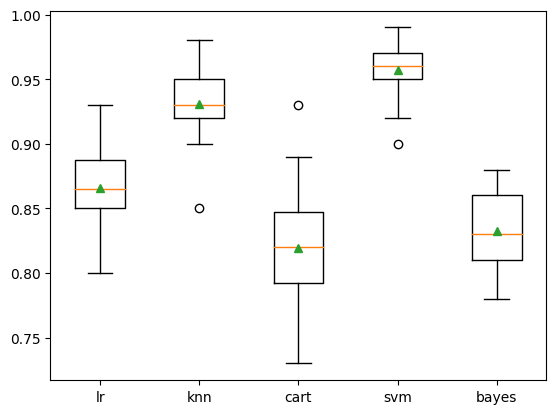

In [9]:
# compare standalone models for binary classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['knn'] = KNeighborsClassifier()
	models['cart'] = DecisionTreeClassifier()
	models['svm'] = SVC()
	models['bayes'] = GaussianNB()
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>lr 0.866 (0.029)
>knn 0.931 (0.025)
>cart 0.821 (0.046)
>svm 0.957 (0.020)
>bayes 0.833 (0.031)
>stacking 0.964 (0.018)


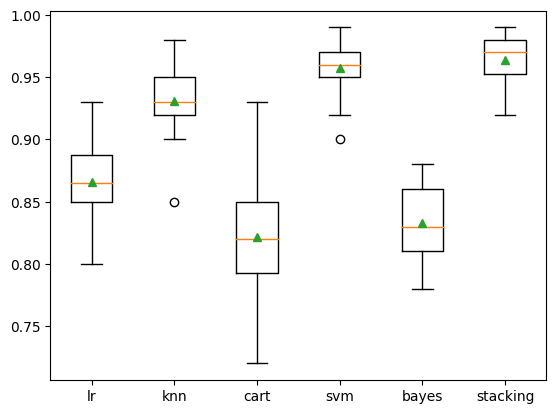

In [10]:
# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
	return X, y

# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('lr', LogisticRegression()))
	level0.append(('knn', KNeighborsClassifier()))
	level0.append(('cart', DecisionTreeClassifier()))
	level0.append(('svm', SVC()))
	level0.append(('bayes', GaussianNB()))
	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

# get a list of models to evaluate
def get_models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['knn'] = KNeighborsClassifier()
	models['cart'] = DecisionTreeClassifier()
	models['svm'] = SVC()
	models['bayes'] = GaussianNB()
	models['stacking'] = get_stacking()
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>knn -101.019 (7.161)
>cart -148.636 (10.752)
>svm -162.419 (12.565)


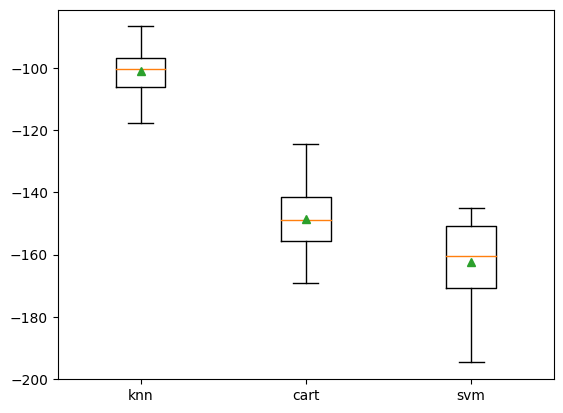

In [11]:
# compare machine learning models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=1)
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	models['knn'] = KNeighborsRegressor()
	models['cart'] = DecisionTreeRegressor()
	models['svm'] = SVR()
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>knn -101.019 (7.161)
>cart -148.753 (11.870)
>svm -162.419 (12.565)
>stacking -56.819 (5.262)


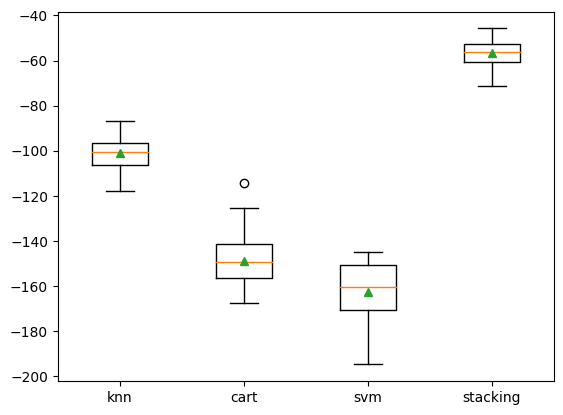

In [12]:
# compare ensemble to each standalone models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=1)
	return X, y

# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('knn', KNeighborsRegressor()))
	level0.append(('cart', DecisionTreeRegressor()))
	level0.append(('svm', SVR()))
	# define meta learner model
	level1 = LinearRegression()
	# define the stacking ensemble
	model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
	return model

# get a list of models to evaluate
def get_models():
	models = dict()
	models['knn'] = KNeighborsRegressor()
	models['cart'] = DecisionTreeRegressor()
	models['svm'] = SVR()
	models['stacking'] = get_stacking()
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Exercise: Are you able to beat the above error? Create a set of blended/stacked regressors that can beat the above errors.

In [13]:
#Code goes here